In [1]:
%cd ..
from jax import value_and_grad, jit
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import pickle
from time import time
from functools import partial
from stencilnet.finite_volume import generate_rectilinear_mesh, u0, advection_solver
from stencilnet.model import init_mlp_params
from stencilnet.optim import mse, symmetry_regularization, update_params

%cd examples/

/Users/jonathan/Desktop/stencilNet
/Users/jonathan/Desktop/stencilNet/examples


In [2]:
# mlp
KEY = random.PRNGKey(1)

params = init_mlp_params(KEY, (9, 4, 1))

I0000 00:00:1706540408.033179       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
# domain
n = 64
x, y = generate_rectilinear_mesh((0, 1), (0, 1), n)
u_init = u0(x, y, type="square")

advection_solver_config = dict(
    u_init=u_init,
    h=(1 / n, 1 / n),
    v=(2, 1),
    T=1,
    cfl=0.8,
    p=3,
    forward="rk4",
    limit_slopes=True,
)

In [4]:
# execute solver
U_before_training = advection_solver(
    **advection_solver_config,
    theta_limiting_params=params,
)

In [5]:
@partial(jit, static_argnums=(1,))
def loss(params, type: str):
    U = advection_solver(
        **advection_solver_config,
        theta_limiting_params=params,
    )
    reg_loss = symmetry_regularization(params)
    if type == "mse":
        mse_loss = mse(U[-1], U[0])
        return mse_loss + reg_loss
    elif type == "mpp":
        mpp_loss = jnp.mean(jnp.square(jnp.where(U[-1] < 0, U[-1], 0))) + jnp.mean(
            jnp.square(jnp.where(U[-1] > 1, U[-1], 0))
        )
        return mpp_loss + reg_loss


for _ in range(10):
    strt = time()
    loss_val, grads = value_and_grad(loss)(params)
    print(f"Computed loss of {loss_val:.5f} in {time()-strt:.2f}s")
    params = update_params(params, grads, 0.5)

Computed loss of 0.05553 in 112.41s
Computed loss of 0.05538 in 73.06s
Computed loss of 0.05523 in 71.82s
Computed loss of 0.05509 in 72.23s
Computed loss of 0.05494 in 73.28s
Computed loss of 0.05479 in 74.30s
Computed loss of 0.05464 in 75.71s
Computed loss of 0.05449 in 73.24s
Computed loss of 0.05434 in 73.68s
Computed loss of 0.05419 in 71.11s


In [6]:
# execute solver
U_after_training = advection_solver(
    **advection_solver_config,
    theta_limiting_params=params,
)

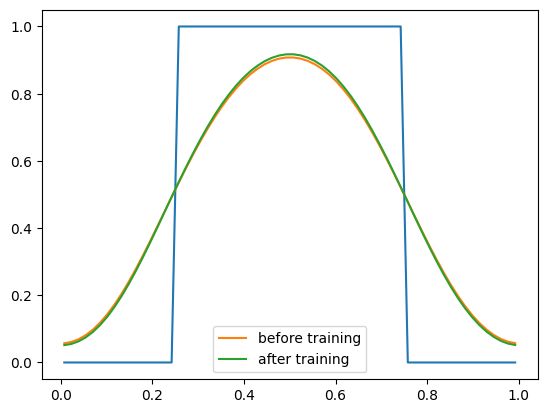

In [7]:
# plot
plt.plot(x[0], U_before_training[0, int(n / 2), :])
plt.plot(x[0], U_before_training[-1, int(n / 2), :], label="before training")
plt.plot(x[0], U_after_training[-1, int(n / 2), :], label="after training")
plt.legend()
plt.show()

In [8]:
%cd ..
with open("models/params.pickle", "wb") as f:
    pickle.dump(params, f)
%cd examples/

/Users/jonathan/Desktop/stencilNet
/Users/jonathan/Desktop/stencilNet/examples


In [9]:
%cd ..
with open("models/params.pickle", "rb") as f:
    params_loaded = pickle.load(f)
%cd examples/

/Users/jonathan/Desktop/stencilNet
/Users/jonathan/Desktop/stencilNet/examples
